In [1]:
# prompt: gdrive mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<IPython.core.display.Javascript object>

Saved to photo.jpg
EAR: 0.347
Driver is Alert.


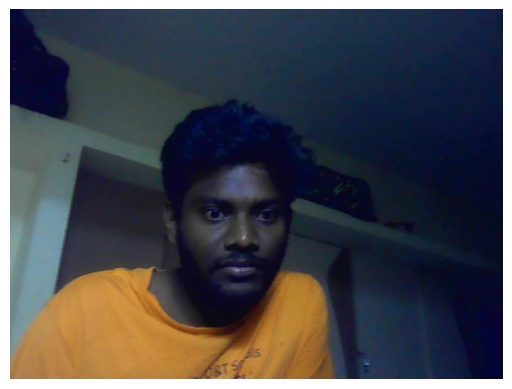

In [3]:
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import os
import time

# EAR threshold for drowsiness
THRESHOLD = 0.25

# Load the dlib facial landmark predictor
PREDICTOR_PATH = "/content/drive/MyDrive/Driver drowsyness /shape_predictor_68_face_landmarks.dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# Function to calculate EAR
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

# Function to take photo using webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = f"""
    async function takePhoto() {{
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);


        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({{ video: true }});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        const dataUrl = canvas.toDataURL('image/jpeg', {quality});
        return dataUrl;
    }}
    """
    # Display the Javascript code and allow it to execute.
    display(Javascript(js))
    # Define the takePhoto function within eval_js to ensure it's defined
    # before calling it.
    eval_js(js)
    # Call the Javascript function and get the result.
    data = eval_js("takePhoto()")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture the photo
filename = take_photo()
print(f"Saved to {filename}")

# Load the captured image
image = cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)

if len(faces) == 0:
    print("No face detected.")
else:
    for face in faces:
        shape = predictor(gray, face)
        shape_np = np.zeros((68, 2), dtype="int")
        for i in range(0, 68):
            shape_np[i] = (shape.part(i).x, shape.part(i).y)

        # Get eye coordinates
        left_eye = shape_np[42:48]
        right_eye = shape_np[36:42]

        # Calculate EAR
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        avg_ear = (left_ear + right_ear) / 2.0

        print(f"EAR: {avg_ear:.3f}")

        # Check for drowsiness
        if avg_ear < THRESHOLD:
            print("⚠️ Drowsiness Detected! ⚠️")
        else:
            print("Driver is Alert.")

# Display the captured image
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()